In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/NLP_sem_7'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/content/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/drive/MyDrive/NLP_sem_7/Group - 46 _ Phishing Email Detection.pdf
/content/drive/MyDrive/NLP_sem_7/Phishing_Email.csv
/content/drive/MyDrive/NLP_sem_7/Group_46_NLP_Email_Phishing.zip
/content/drive/MyDrive/NLP_sem_7/phishing_email_test.ipynb
/content/drive/MyDrive/NLP_sem_7/phishing_email_detection_colab_compatible.ipynb
/content/drive/MyDrive/NLP_sem_7/models/8_model_lstm.keras
/content/drive/MyDrive/NLP_sem_7/models/9_model_bi_lstm.keras
/content/drive/MyDrive/NLP_sem_7/models/7_model_rnn.keras
/content/drive/MyDrive/NLP_sem_7/models/tfidf_vectorizer.pkl
/content/drive/MyDrive/NLP_sem_7/models/1_model_naive_bayes.pkl
/content/drive/MyDrive/NLP_sem_7/models/2_model_logistic_regression.pkl
/content/drive/MyDrive/NLP_sem_7/models/3_model_sgd_classifier.pkl
/content/drive/MyDrive/NLP_sem_7/models/4_model_decision_tree.pkl
/content/drive/MyDrive/NLP_sem_7/models/5_model_random_forest.pkl
/content/drive/MyDrive/NLP_sem_7/models/6_model_mlp.pkl


# *1* Import Necessary libs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding,GRU,LSTM,Bidirectional,SimpleRNN
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense,Dropout
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')

# *2*  Loading our data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NLP_sem_7/Phishing_Email.csv")

df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


# 4| Text Preprocessing

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
Email Text,16
Email Type,0


** There are 16 rows available that have null values .Let's remove these rows



## 4.1| Drop duplicates and null values

In [ ]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.dropna(inplace=True,axis=0)
df.drop_duplicates(inplace=True)

In [ ]:
print("Dimension of the row data:",df.shape)

Dimension of the row data: (17538, 2)


In [ ]:
df.head()

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [ ]:
# Create the bar chart
fig = px.bar(df['Email Type'].value_counts(), x=df['Email Type'].value_counts().index, y=df['Email Type'].value_counts().values,
             color=['blue', 'red'], labels={'x': 'Category', 'y': 'Count'},
             title="Categorical Distribution")

# Show the plot
fig.show()

Insigths :

The count of the safe emails is more than that of phishing email so if we see any emails that look like phishing delete

In [ ]:
# Create the pie chart
fig_pie = px.pie(df['Email Type'].value_counts(), names=df['Email Type'].value_counts().index,
                 values=df['Email Type'].value_counts().values, title="Categorical Distribution")

# Show the pie chart
fig_pie.show()

## 4.3| Integer Encoding

In [ ]:
le = LabelEncoder()

df["Email Type"] = le.fit_transform(df["Email Type"])

In [ ]:
df

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",1
1,the other side of * galicismos * * galicismo *...,1
2,re : equistar deal tickets are you still avail...,1
3,\nHello I am your hot lil horny toy.\n I am...,0
4,software at incredibly low prices ( 86 % lower...,0
...,...,...
18644,\nRick Moen a Ã©crit:> > I'm confused. I thou...,1
18645,date a lonely housewife always wanted to date ...,0
18646,request submitted : access request for anita ....,1
18647,"re : important - prc mtg hi dorn & john , as y...",1


## 4.4 Remove hyperlinks, punctuations, extra space

In [ ]:
import re

def preprocess_text(text):
    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Apply the preprocess_text function to the specified column in the DataFrame
df["Email Text"] =df["Email Text"].apply(preprocess_text)

In [ ]:
df.head()

,Email Text,Email Type
0,re 6 1100 disc uniformitarianism re 1086 sex l...,1
1,the other side of galicismos galicismo is a sp...,1
2,re equistar deal tickets are you still availab...,1
3,hello i am your hot lil horny toy i am the one...,0
4,software at incredibly low prices 86 lower dra...,0


# WordCloud

## wordcloud of avaiable stopwords

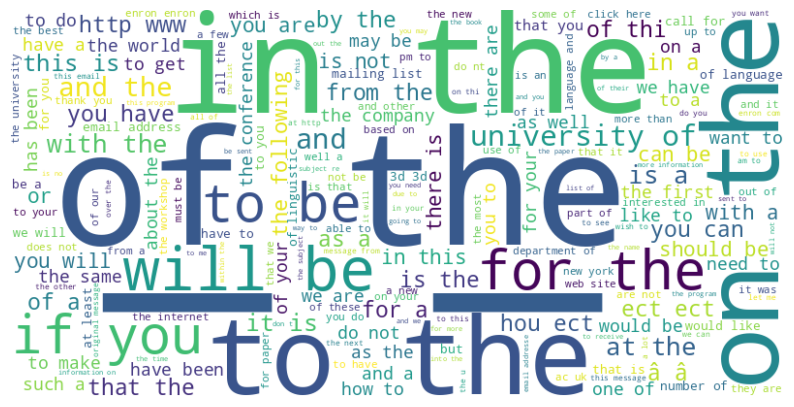

In [ ]:
from wordcloud import WordCloud

#combine all rows into a single string
all_mails = " ".join(df['Email Text'])

#create a wordcloud object
word_cloud = WordCloud(stopwords="english",width=800,height=400,background_color='white').generate(all_mails)

plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

## wordcloude of unique words

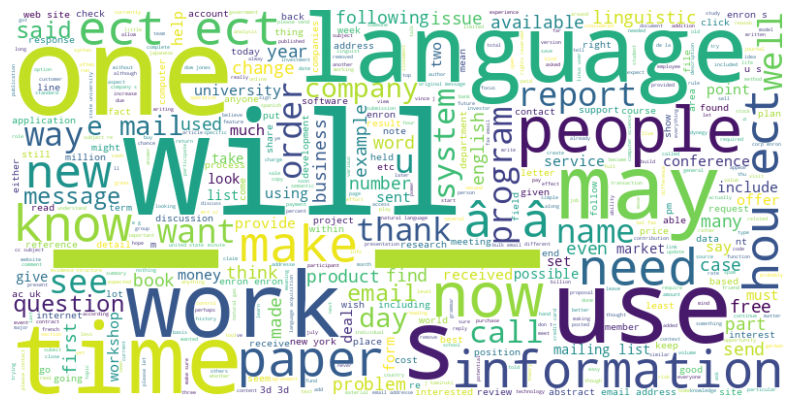

In [ ]:
#combine all rows into a single string
all_mails = " ".join(df['Email Text'])

#create a wordcloud object
word_cloud = WordCloud(width=800,height=400,background_color='white',max_words=10000).generate(all_mails)
plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

## 4.5 Converting text into vector

### 4.5.1 Tfidf vectorizer

In [ ]:
tf = TfidfVectorizer(stop_words="english",max_features=10000) #dimension reduction

feature_x = tf.fit_transform(df["Email Text"]).toarray()

In [ ]:
feature_x.shape

(17538, 10000)

In [ ]:
import joblib
joblib.dump(tf, 'tfidf_vectorizer.pkl')  # Save the trained TfidfVectorizer


['tfidf_vectorizer.pkl']

In [ ]:
y_tf = np.array(df['Email Type']) # convert the label into numpy array

### 4.5.2 Splitting into train and test

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(feature_x,y_tf,train_size=0.8,random_state=0)

# 5| Applying different algorithm

## 5.1| Naive Bayes

In [ ]:
#naive bayes works with condtional probability
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train,y_train)

MultinomialNB()

accuracy from native bayes: 97.52 %
f1 score from naive bayes: 97.99 %
classification report :

               precision    recall  f1-score   support

           0       0.97      0.96      0.97      1351
           1       0.98      0.98      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.97      0.97      0.97      3508
weighted avg       0.98      0.98      0.98      3508



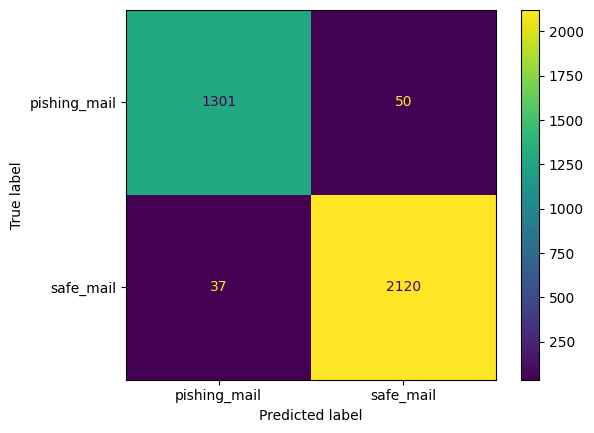

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
pred_nav = nb.predict(x_test)

# Checking the performance

print(f"accuracy from native bayes: {accuracy_score(y_test,pred_nav)*100:.2f} %")
print(f"f1 score from naive bayes: {f1_score(y_test,pred_nav)*100:.2f} %")
print("classification report :\n\n",classification_report(y_test,pred_nav))

#confusion matrix
clf_nav = confusion_matrix(y_test,pred_nav)
cx_ = ConfusionMatrixDisplay(clf_nav,display_labels=['pishing_mail','safe_mail']).plot()
plt.show()

## 5.2| Logistic Regression


accuracy from logistic regression:97.98 %
f1 score from logistic regression: 98.36 %
classification report : 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      1351
           1       0.98      0.99      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



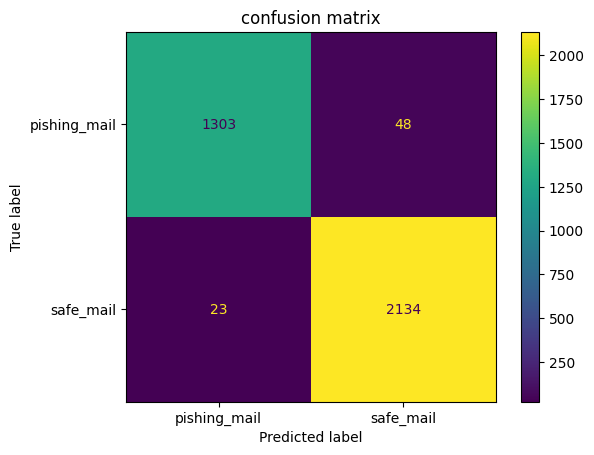

In [ ]:
lg = LogisticRegression()
lg.fit(x_train,y_train)

# prediction
pred_lg = lg.predict(x_test)
# performance
print("")
print(f"accuracy from logistic regression:{accuracy_score(y_test,pred_lg)*100:.2f} %")
print(f"f1 score from logistic regression: {f1_score(y_test,pred_lg)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_lg))

clf_lg = confusion_matrix(y_test,pred_lg)
cx_ = ConfusionMatrixDisplay(clf_lg,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

In [ ]:
# save the model for future use

import joblib

# Save the trained model to a file
joblib.dump(nb, 'email_spam_nb.pkl')

['email_spam_nb.pkl']

## 5.3| SGD Classifier

accuracy from logistic regression:98.20 %
f1 score from logistic regression: 98.55 %
classification report : 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1351
           1       0.98      0.99      0.99      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



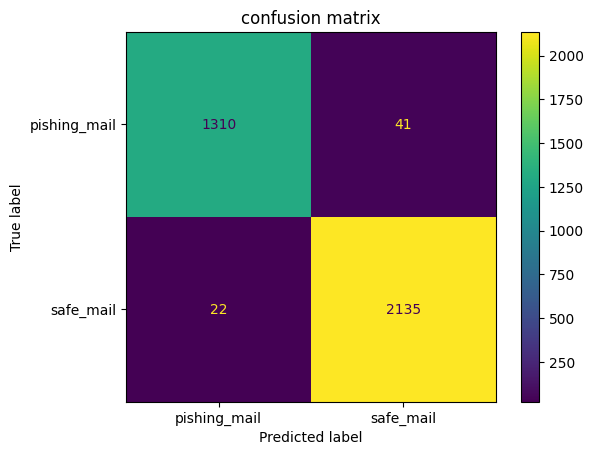

In [ ]:
from sklearn.linear_model import SGDClassifier

# passing object
sgd = SGDClassifier()
sgd.fit(x_train,y_train)

# prediction
pred_sgd = sgd.predict(x_test)
# performance
print(f"accuracy from logistic regression:{accuracy_score(y_test,pred_sgd)*100:.2f} %")
print(f"f1 score from logistic regression: {f1_score(y_test,pred_sgd)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_sgd))

clf_sgd = confusion_matrix(y_test,pred_sgd)
cx_ = ConfusionMatrixDisplay(clf_sgd,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.5| Decision Tree

In [ ]:
dtr = DecisionTreeClassifier() #passing object
dtr.fit(x_train,y_train)

#prediction
pred_dtr = dtr.predict(x_test)

#performance
print(f"accuracy from Decision Tree:{accuracy_score(y_test,pred_dtr)*100:.2f} %")
print(f"f1 score from Decision Tree: {f1_score(y_test,pred_dtr)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_dtr))

#confusion matrix
clf_dtr = confusion_matrix(y_test,pred_dtr)
cx_ = ConfusionMatrixDisplay(clf_dtr,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.6| Random Forest

accuracy from rnadom forest:97.75 %
f1 score from random forest: 98.16 %
classification report : 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1351
           1       0.98      0.98      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



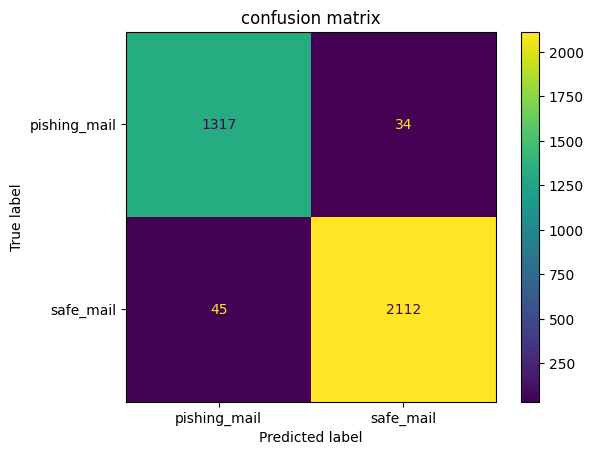

In [ ]:
rnf = RandomForestClassifier() #passing object
rnf.fit(x_train,y_train)

#prediction
pred_rnf = rnf.predict(x_test)

#performance
print(f"accuracy from rnadom forest:{accuracy_score(y_test,pred_rnf)*100:.2f} %")
print(f"f1 score from random forest: {f1_score(y_test,pred_rnf)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_rnf))

#confusion matrix
clf_rnf = confusion_matrix(y_test,pred_rnf)
cx_ = ConfusionMatrixDisplay(clf_rnf,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.7| MLP Classifier (Multi-Layer perceptrons)

accuracy from MLP:98.40 %
f1 score from MLP: 98.70 %
classification report : 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1351
           1       0.99      0.99      0.99      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



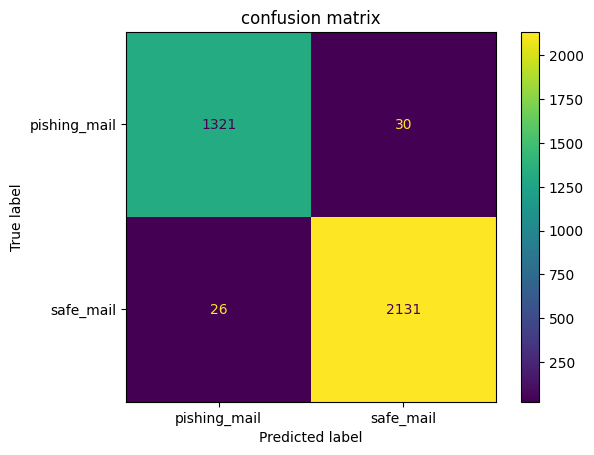

In [ ]:
mlp = MLPClassifier()  # passing object
mlp.fit(x_train,y_train)

#prediction
pred_mlp = mlp.predict(x_test)

#performance
print(f"accuracy from MLP:{accuracy_score(y_test,pred_mlp)*100:.2f} %")
print(f"f1 score from MLP: {f1_score(y_test,pred_mlp)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_mlp))

#confusion matrix
clf_mlp = confusion_matrix(y_test,pred_mlp)
cx_ = ConfusionMatrixDisplay(clf_mlp,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.8| EDA comparison of the models performances

In [ ]:
models = ['Naive bayes', 'Logistic Regression', 'SGD Classifier', 'Decision Tree', 'Random Forest', 'MLPClassifier']
accuracies = [97.52, 97.95, 98.57, 93.67, 97.72, 98.29]

# Create the bar chart
fig = px.bar(x=models, y=accuracies, labels={'x': 'Models', 'y': 'Accuracy'},
             title="Performance of the models", text=accuracies)

# Customize the layout (optional)
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside', marker_color='magenta')

# Show the plot
fig.show()

# 6| NN (Neural Network)

In [ ]:
max_len = 150

tk = Tokenizer()

# Process the text

tk.fit_on_texts(df['Email Text'])
sequences = tk.texts_to_sequences(df['Email Text'])
vector = pad_sequences(sequences,padding='post', maxlen=max_len)

In [ ]:
len(vector)

17538

In [ ]:
x = np.array(vector)
y = np.array(df["Email Type"])

In [ ]:
#Split the dataset into train and test set

x_train, x_test, y_train, y_test = train_test_split(vector,df['Email Type'], test_size=0.2, random_state =0)

## 6.1| Simple RNN

In [ ]:
model_smp = Sequential() # Sequential() API
model_smp.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=50,input_length=150))
model_smp.add(SimpleRNN(units=100))
model_smp.add(Dropout(0.45))
model_smp.add(Dense(1, activation='sigmoid'))

In [ ]:
model_smp.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [ ]:
model_smp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
historical_smp  = model_smp.fit(x_train,y_train, epochs=7, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.5873 - loss: 0.6941 - val_accuracy: 0.6793 - val_loss: 0.5824
Epoch 2/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.6960 - loss: 0.5452 - val_accuracy: 0.7078 - val_loss: 0.5252
Epoch 3/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.7431 - loss: 0.4434 - val_accuracy: 0.7161 - val_loss: 0.5986
Epoch 4/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.7492 - loss: 0.4203 - val_accuracy: 0.6998 - val_loss: 0.5187
Epoch 5/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.7572 - loss: 0.3989 - val_accuracy: 0.7109 - val_loss: 0.5128
Epoch 6/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7977 - loss: 0.4129 - val_accuracy: 0.7135 - val_loss: 0.5112
Epoch 7/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.7451 - loss: 0.4205 - val_accuracy: 0.7158 - val_loss: 0.4912


In [ ]:
import matplotlib.pyplot as plt
pd.DataFrame(historical_smp.history)

pd.DataFrame(historical_smp.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_smp.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
y_pred_prob_smp = model_smp.predict(x_test)
y_pred_smp = (y_pred_prob_smp > 0.5).astype(int)

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cnf_smp = confusion_matrix(y_test,y_pred_smp)
ax_smp = ConfusionMatrixDisplay(confusion_matrix=cnf_smp,display_labels=['pishing','normal']).plot()
plt.title("Confusion Matrix")
plt.show()

## 6.2| LSTM Architecture

In [ ]:
model = Sequential() # Sequential() API
model.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=50,input_length=150))
model.add(LSTM(units=100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
historical  = model.fit(x_train,y_train, epochs=5, batch_size=16, validation_data=(x_test,y_test))

## 7| Performance

In [ ]:
results = model.evaluate(x_test, y_test)
loss = results[0]  # Extract the loss from the results
accuracy = results[1]  # Extract the accuracy from the results

print(f"Model Loss: {loss}")
print(f"Model Accuracy: {accuracy*100}")

In [ ]:
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

In [ ]:
pd.DataFrame(historical.history)

pd.DataFrame(historical.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

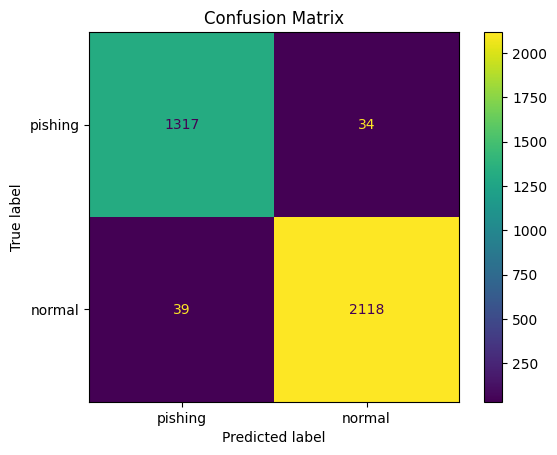

In [ ]:
cnf = confusion_matrix(y_test,y_pred)
ax = ConfusionMatrixDisplay(confusion_matrix=cnf,display_labels=['pishing','normal'])
ax.plot()
plt.title("Confusion Matrix")
plt.show()

# 8| Bidirectional

In [ ]:
model_bi = Sequential() # Sequential() API
model_bi.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=50,input_length=150))
model_bi.add(Bidirectional(LSTM(units=100)))
model_bi.add(Dropout(0.5))
model_bi.add(Dense(1, activation='sigmoid'))

In [ ]:
model_bi.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [ ]:
model_bi.summary()

In [ ]:
historical  = model_bi.fit(x_train,y_train, epochs=2, batch_size=16, validation_data=(x_test,y_test))

In [ ]:
model_bi.evaluate(x_test,y_test)

In [ ]:
y_pred_prob_bi = model_bi.predict(x_test)
y_pred_bi = (y_pred_prob_bi > 0.5).astype(int)

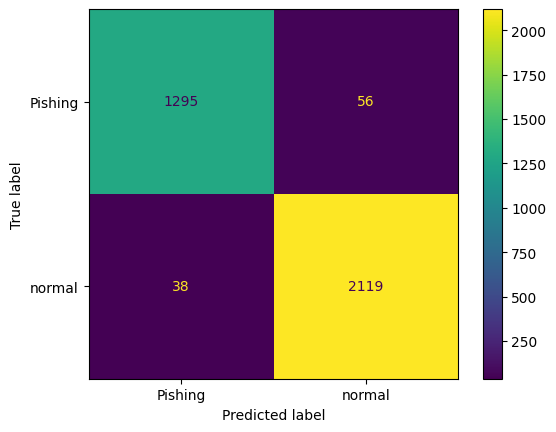

In [ ]:
cnf_bi = confusion_matrix(y_test,y_pred_bi)
ax_bi = ConfusionMatrixDisplay(confusion_matrix=cnf_bi,display_labels=['Pishing','normal'])
ax_bi.plot()
plt.show()

In [ ]:
joblib.dump(nb, '1_model_naive_bayes.pkl')
joblib.dump(lg, '2_model_logistic_regression.pkl')
joblib.dump(sgd, '3_model_sgd_classifier.pkl')
joblib.dump(dtr, '4_model_decision_tree.pkl')
joblib.dump(rnf, '5_model_random_forest.pkl')
joblib.dump(mlp, '6_model_mlp.pkl')

['9_model_lstm_bi.pkl']

In [ ]:
model_smp.save("model_smp.keras") # 6.1 Simple RNN, epoch = 7
model.save("model.keras") # 6.2 LSTM, epoch = 5
model_bi.save("model_bi.keras") # 8 Bidirectional, epoch = 2

<h1>NLP models</h1>

<h2>HMM (Hidden Markov Model)</h2>

In [ ]:
!pip install hmmlearn
from hmmlearn import hmm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 4.8 MB/s eta 0:00:00


In [ ]:
from hmmlearn import hmm
import numpy as np

# Number of hidden states (2: phishing and safe email)
n_components = 2

# Initialize HMM
hmm_model = hmm.MultinomialHMM(n_components=n_components, random_state=0, n_iter=100)

# Initialize start probabilities (must sum to 1)
hmm_model.startprob_ = np.array([0.5, 0.5])  # Assuming equal probability for both states initially

# Initialize transition matrix (rows must sum to 1)
hmm_model.transmat_ = np.array([
    [0.7, 0.3],  # Probabilities of staying in state 0 or transitioning to state 1
    [0.4, 0.6]   # Probabilities of staying in state 1 or transitioning to state 0
])

# Fit the model
lengths = [1] * x_train.shape[0]  # Each vector is an independent observation
hmm_model.fit(x_train, lengths=lengths)

# Predict on test data
test_lengths = [1] * x_test.shape[0]
pred_hmm = hmm_model.predict(x_test, lengths=test_lengths)

# Evaluate
print(f"Accuracy from HMM: {accuracy_score(y_test, pred_hmm)*100:.2f} %")
print(f"F1 Score from HMM: {f1_score(y_test, pred_hmm)*100:.2f} %")
print("Classification Report:\n", classification_report(y_test, pred_hmm))

# Confusion Matrix
clf_hmm = confusion_matrix(y_test, pred_hmm)
cx_ = ConfusionMatrixDisplay(clf_hmm, display_labels=['phishing_mail', 'safe_mail']).plot()
plt.title("Confusion Matrix - HMM")
plt.show()


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


ValueError: transmat_ rows must sum to 1 (got row sums of [0. 0.])

In [ ]:
!pip install sklearn_crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.3 MB/s eta 0:00:00


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Starting HMM model training...
Initializing HMM model...
Fitting HMM model...


Evaluating model...


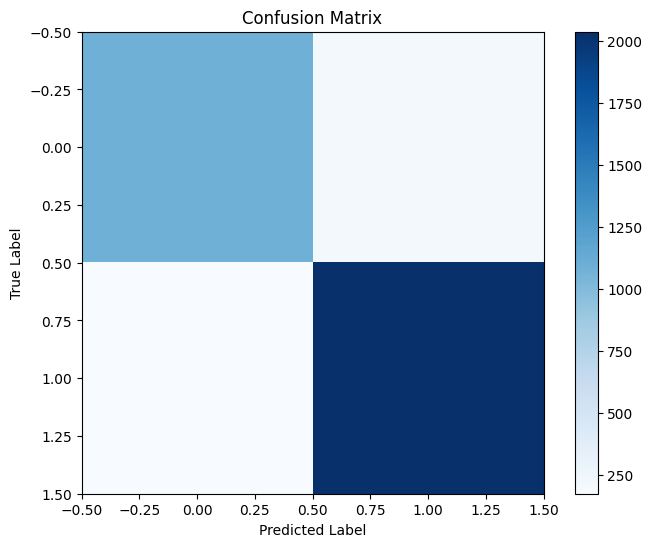

HMM Model Accuracy: 89.05%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1295
           1       0.91      0.92      0.91      2213

    accuracy                           0.89      3508
   macro avg       0.88      0.88      0.88      3508
weighted avg       0.89      0.89      0.89      3508



In [ ]:
import numpy as np
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

class HMMPhishingDetector:
    def __init__(self, n_components=2, n_features=1000):
        self.n_components = n_components
        self.n_features = n_features
        self.vectorizer = CountVectorizer(max_features=n_features)

        # Initialize two HMM models - one for phishing and one for legitimate
        self.hmm_phishing = hmm.MultinomialHMM(n_components=n_components)
        self.hmm_legitimate = hmm.MultinomialHMM(n_components=n_components)

    def prepare_sequence_data(self, X, fit=False):
        # Convert text data to sequences of word indices
        if fit:
            X_vec = self.vectorizer.fit_transform(X).toarray()
        else:
            X_vec = self.vectorizer.transform(X).toarray()
        # Reshape for HMM (n_samples, n_timesteps, n_features)
        return X_vec.reshape(-1, 1, self.n_features)

    def fit(self, X, y):
        # Prepare data - fit and transform during training
        X_sequences = self.prepare_sequence_data(X, fit=True)

        # Split data into phishing and legitimate
        X_phish = X_sequences[y == 0]
        X_legit = X_sequences[y == 1]

        # Initialize and set starting probabilities
        startprob_phish = np.array([0.6, 0.4])  # Example starting probabilities
        startprob_legit = np.array([0.4, 0.6])

        self.hmm_phishing.startprob_ = startprob_phish
        self.hmm_legitimate.startprob_ = startprob_legit

        # Fit HMM models with proper input shape
        self.hmm_phishing.fit(X_phish.reshape(-1, self.n_features))
        self.hmm_legitimate.fit(X_legit.reshape(-1, self.n_features))

        return self

    def predict(self, X):
        # Transform only (don't fit) for prediction
        X_sequences = self.prepare_sequence_data(X, fit=False)
        predictions = []

        for sequence in X_sequences:
            # Calculate log probability for both models
            score_phishing = self.hmm_phishing.score(sequence)
            score_legitimate = self.hmm_legitimate.score(sequence)

            # Classify based on higher probability
            predictions.append(1 if score_legitimate > score_phishing else 0)

        return np.array(predictions)

    def evaluate(self, X_test, y_test):
        # Make predictions
        y_pred = self.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        return accuracy, report, conf_matrix

# Example usage with proper error handling
def train_hmm_model(df):
    try:
        # Prepare data
        X = df['Email Text'].values  # Convert to numpy array
        y = df['Email Type'].values

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize and train model
        print("Initializing HMM model...")
        hmm_detector = HMMPhishingDetector(n_components=3, n_features=1000)

        print("Fitting HMM model...")
        hmm_detector.fit(X_train, y_train)

        print("Evaluating model...")
        accuracy, report, conf_matrix = hmm_detector.evaluate(X_test, y_test)

        print(f"HMM Model Accuracy: {accuracy * 100:.2f}%")
        print("\nClassification Report:")
        print(report)

        return hmm_detector

    except Exception as e:
        print(f"Error during training: {str(e)}")
        raise

# Train and evaluate the HMM model
print("Starting HMM model training...")
hmm_model = train_hmm_model(df)

In [ ]:
import joblib
joblib.dump(hmm_model, 'hmm_phishing_detector.pkl')

['hmm_phishing_detector.pkl']

In [ ]:
import numpy as np
import scipy.optimize as optimize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import matplotlib.pyplot as plt
import joblib
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
nltk.download('punkt')

class MEMMPhishingDetector:
    def __init__(self, n_features=1000):
        self.n_features = n_features
        self.vectorizer = TfidfVectorizer(max_features=n_features)
        self.weights = None

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def feature_function(self, x, y):
        # Combine email features with previous state
        return np.concatenate([x, [y]])

    def calculate_likelihood(self, weights, X, y):
        total_likelihood = 0
        for i in range(1, len(X)):
            features = self.feature_function(X[i], y[i-1])
            prob = self.sigmoid(np.dot(weights, features))
            total_likelihood += y[i] * np.log(prob) + (1 - y[i]) * np.log(1 - prob)
        return -total_likelihood  # Negative for minimization

    def fit(self, X, y):
        # Transform text data
        X_transformed = self.vectorizer.fit_transform(X).toarray()

        # Initialize weights
        initial_weights = np.zeros(self.n_features + 1)  # +1 for previous state

        # Optimize weights using L-BFGS-B
        result = optimize.minimize(
            fun=self.calculate_likelihood,
            x0=initial_weights,
            args=(X_transformed, y),
            method='L-BFGS-B'
        )

        self.weights = result.x
        return self

    def predict(self, X):
        X_transformed = self.vectorizer.transform(X).toarray()
        predictions = []
        prev_state = 0  # Initial state

        for x in X_transformed:
            features = self.feature_function(x, prev_state)
            prob = self.sigmoid(np.dot(self.weights, features))
            pred = 1 if prob > 0.5 else 0
            predictions.append(pred)
            prev_state = pred

        return np.array(predictions)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        return accuracy, report, conf_matrix

class CRFPhishingDetector:
    def __init__(self, algorithm='lbfgs', max_iterations=100):
        self.model = sklearn_crfsuite.CRF(
            algorithm=algorithm,
            max_iterations=max_iterations,
            all_possible_transitions=True
        )

    def extract_features(self, text):
        tokens = word_tokenize(text.lower())

        # Extract various features
        features = {
            'word_count': len(tokens),
            'avg_word_length': np.mean([len(w) for w in tokens]),
            'contains_url': 1 if any(word.startswith(('http', 'www')) for word in tokens) else 0,
            'contains_currency': 1 if any(c in text for c in '$€£¥') else 0,
            'contains_numbers': 1 if any(c.isdigit() for c in text) else 0
        }

        # Add n-gram features
        bigrams = list(ngrams(tokens, 2))
        trigrams = list(ngrams(tokens, 3))

        for gram in bigrams[:10]:  # Limit to first 10 bigrams
            features[f'bigram_{"_".join(gram)}'] = 1

        for gram in trigrams[:10]:  # Limit to first 10 trigrams
            features[f'trigram_{"_".join(gram)}'] = 1

        return features

    def prepare_data(self, texts):
        return [self.extract_features(text) for text in texts]

    def fit(self, X, y):
        X_features = self.prepare_data(X)
        # CRF expects a sequence of labels
        y = [[label] for label in y]

        self.model.fit(X_features, y)
        return self

    def predict(self, X):
        X_features = self.prepare_data(X)
        predictions = self.model.predict(X_features)
        # Flatten predictions since we're working with single labels
        return np.array([p[0] for p in predictions])

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        return accuracy, report, conf_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
X = df['Email Text'].values
y = df['Email Type'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate MEMM
print("Training MEMM model...")
memm_model = MEMMPhishingDetector()
memm_model.fit(X_train, y_train)
memm_accuracy, memm_report, _ = memm_model.evaluate(X_test, y_test)
print(f"MEMM Accuracy: {memm_accuracy:.2f}")
print("MEMM Report:\n", memm_report)


# Save models
joblib.dump(memm_model, 'memm_phishing_detector.pkl')

Training MEMM model...
MEMM Accuracy: 0.96
MEMM Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      1295
           1       0.97      0.97      0.97      2213

    accuracy                           0.96      3508
   macro avg       0.96      0.96      0.96      3508
weighted avg       0.96      0.96      0.96      3508



['memm_phishing_detector.pkl']

## Testing on Pesonal Emails

In [ ]:
df_test = pd.DataFrame({
    'Email Text': [
        '''Greetings Everyone, We hope you are all doing well and are as excited as we are! Team Eifer is thrilled to bring you two upcoming sports tournaments: the Kho Kho Tournament for Girls and the Kabaddi Tournament for Boys. These events are set to be action-packed and full of excitement, giving everyone an opportunity to showcase their skills, passion, and sportsmanship. Event Details Kho Kho Tournament (Only Girls): Girls can participate either branch-wise or batch-wise, giving flexibility for team formation. Kabaddi Tournament (Only Boys): For B.Tech students, teams should be formed branch-wise, while for MBA, M.Sc., and M.Tech students, teams should be formed year-wise. We invite all enthusiastic students to join and make the most of this competitive platform. Registration Links To ensure smooth registration, we have provided the links below. Don’t miss out on this chance to be a part of the action! Kho Kho Tournament (Girls) https://forms.gle/abRzy6JN2tRQHsDYA Kabaddi Tournament (Boys) https://forms.gle/CCkBHxeoWYq4umhT6 Important Dates to Remember Registration Deadline: November 13, 2024 (until 11:59 P.M.) Tournament Dates: November 15 - 17, 2024 . Whether you're experienced or trying out a new sport, we encourage everyone to participate. This is a wonderful opportunity to connect with your peers, experience the thrill of competition, and create lasting memories on the field. For any questions or more details, please feel free to reach out to the Sports Society. We look forward to your participation and to making these tournaments a grand success. Let’s come together to celebrate the spirit of teamwork, resilience, and sportsmanship! Warm regards, Team Eifer.''',
        '''A new sign-in on Windows lit2021024@iiitl.ac.in We noticed a new sign-in to your Google Account on a Windows device. If this was you, you don’t need to do anything. If not, we’ll help you secure your account. Check activity You can also see security activity at https://myaccount.google.com/notifications''',
        '''Hello Everyone, "Greetings" This is a reminder for all groups to be prepared for their final project viva. Each group will receive an email with the viva schedule, so please keep a close watch on your inbox. The invitation link for your viva will be sent 2-3 hours before the scheduled time. Note that I will not accept any excuses related to travel, network issues, or other delays, as all vivas must be completed by the end of November 15th. For those who have already completed their viva, please verify your marks on Google Classroom. If you notice any discrepancies, inform your CR (Class Representative), who will contact me on your behalf. Additionally, if your viva is complete but you haven’t yet uploaded your project files, email them to me by the end of today with "High Priority" in the subject line. Please remember to check your email and Google Classroom regularly for updates. Regards Dr G.''',
        '''Hurry up! Last chance to book the slot. WIPRO CERTIFIED TRAINING & INTERNSHIP PROGRAM 2024 Hello Students, Greetings from Krutanic Company! Join us and top MNCs like IBM, Microsoft, Deloitte, Cognizant, Barclays, Infosys, Genpact, Oracle, TCS, and more! We're excited to offer a comprehensive 3-month online Training, Internship, and Job Guarantee Program designed to give you real-world experience and industry-ready skills. Why Choose Us? Learn from Industry Experts: Engage in theoretical learning and live interactive sessions with professionals boasting 15+ years of experience. Real-time Projects: Apply your knowledge to real projects, build an impressive resume, and stand out in job applications. Placement Assistance: Benefit from mock interviews, group discussions, resume building, and personality development sessions. Our placement package offers up to 10 LPA! IMPORTANT NOTICE - A NOMINAL TRAINING FEE IS APPLICABLE...! Program Structure 1️⃣ First Month: Theoretical learning from industry experts. Live interactive sessions and doubt-clearing sessions. Weekly 4-5 sessions via Zoom or Google Meet. 2️⃣ Second Month: Application of learned concepts. Real-time projects with mentor assistance. Minor Project: Individual (7 days). Major Project: Group (21 days). 3️⃣ Third Month: Placement Assistance: Multiple sessions including mock interviews, group discussions, resume building, and personality development. Perks and Benefits: ✅ Access to recorded sessions on the LMS portal for 6 months. ✅ Complimentary resume building and interview preparation access. ✅ Unlimited placement opportunities through our Krutanic growth community. ✅ Real-world projects curated by industry-certified professionals. ✅ Career opportunities from startups and MNCs based on your performance. Certifications and Recognition: 🎓 Training completion certificate co-branded with ISO and WIPRO approval. 🎓 Internship completion certificate from MNCs. 🏅 Outstanding Performer Certificate based on performance. 🏅 Letter of Recommendation from MNCs. 🏅 Real-time industrial-grade projects to enhance your resume/CV. 🎯 Placement assistance from industry experts working at top companies like TCS, IBM, Microsoft, Accenture, Cognizant, PwC, J.P. Morgan, Deloitte, and more. 📌  REFERRAL CODE:- KRT14 (Use mandatory Referral code) Apply now and receive your offer letter within 24 hours! Not satisfied? Looking for a customized internship experience? Fill out the form below to get an internship tailored to your needs. For queries or doubts, call or WhatsApp us at +91 89516 94573, 9980549623. Best Regards, Team Krutanic. Fill out in Google Forms Powered by Google Forms''',
        '''Hello I am your hot lil horny toy. I am the one you dream About, I am a very open minded person, Love to talk about and any subject. Fantasy is my way of life, Ultimate in sex play.     Ummmmmmmmmmmmmm I am Wet and ready for you.     It is not your looks but your imagination that matters most, With My sexy voice I can make your dream come true... Hurry Up! call me let me Cummmmm for you.......................... TOLL-FREE:             1-877-451-TEEN (1-877-451-8336)For phone billing:     1-900-993-2582 -- _______________________________________________ Sign-up for your own FREE Personalized E-mail at Mail.com http://www.mail.com/?sr=signup''',
        ],
})

df_test

,Email Text
0,"Greetings Everyone, We hope you are all doing ..."
1,A new sign-in on Windows lit2021024@iiitl.ac.i...
2,"Hello Everyone, ""Greetings"" This is a reminder..."
3,Hurry up! Last chance to book the slot. WIPRO ...
4,Hello I am your hot lil horny toy. I am the on...


In [ ]:
y_test = np.array([1, 1, 1, 1, 0])
y_test

array([1, 1, 1, 1, 0])

In [ ]:
from joblib import load

def get_features(df):
  # drop na
  df.dropna(inplace=True,axis=0)
  df.drop_duplicates(inplace=True)

  # preprocess text
  df["Email Text"] = df["Email Text"].apply(preprocess_text)

  # vectorize
  # use the same vocabulary as was in training
  # tf = load('tfidf_vectorizer.pkl')

  # extract feature vector, DO NOT FIT_TRANSFORM
  # X = tf.fit_transform(df["Email Text"]).toarray()
  X = tf.transform(df["Email Text"]).toarray()
  return X

X = get_features(df_test)
X.shape

(5, 10000)

In [ ]:
from joblib import load

hmm_model = load('/content/drive/MyDrive/NLP_sem_7/models/hmm_phishing_detector (1).pkl')
memm_model = load('/content/drive/MyDrive/NLP_sem_7/models/memm_phishing_detector.pkl')

In [ ]:
models = [hmm_model, memm_model]

for model in models:
  model_name = type(model).__name__
  pred = model.predict(df_test["Email Text"])
  print(f"prediction {pred} accuracy {accuracy_score(y_test, pred)*100:.2f}% | {model_name}")


prediction [1 0 1 1 0] accuracy 80.00% | HMMPhishingDetector
prediction [1 0 1 0 0] accuracy 60.00% | MEMMPhishingDetector


In [ ]:
models = [nb, lg, sgd, dtr, rnf, mlp]

for model in models:
  model_name = type(model).__name__
  pred = model.predict(X)
  # pred_spam_ham = ['H' if value > 0.5 else 'S' for value in pred]
  print(f"prediction {pred} accuracy {accuracy_score(y_test, pred)*100:.2f}% | {model_name}")


prediction [1 0 1 1 0] accuracy 80.00% | MultinomialNB
prediction [1 0 1 1 0] accuracy 80.00% | LogisticRegression
prediction [1 0 1 1 0] accuracy 80.00% | SGDClassifier
prediction [1 0 1 0 0] accuracy 60.00% | DecisionTreeClassifier
prediction [1 0 1 1 0] accuracy 80.00% | RandomForestClassifier
prediction [1 1 1 1 0] accuracy 100.00% | MLPClassifier


In [ ]:
df_test

,Email Text
0,greetings everyone we hope you are all doing w...
1,a new signin on windows lit2021024iiitlacin we...
2,hello everyone greetings this is a reminder fo...
3,hurry up last chance to book the slot wipro ce...
4,hello i am your hot lil horny toy i am the one...


### Thanks Dr.Gaurav Sharma ###
